In [1]:
import numpy as np
from scipy.stats import ks_2samp, ks_1samp, kstest
import json
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
import os

In [2]:
import re
def match_regex_array(files, regex):
    matches = [re.findall(regex, f) for f in files]
    matches = ["./sim_results/" + m[0] for m in matches if len(m) > 0 ]
    return matches

In [3]:
# Apply KS-test using a large number of samples from the reference distribution 
# and a small sample from a "test" (in this case, the Network-Aware) distribution multiple times
# Each test sample represents a bot consuming contents from NA-distribution
# Function returns the mean of the p_values for all KS-tests performed for each bot
# and the proportion of null hypothesis rejection, i.e., samples were not generated from the same distribution
def covertness_kstest(ref_dist, test_dist, population, ref_dist_size=10**6, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_mean_rounds = []
    rejection_proportions_rounds = []
    ref_dist_large_samples = choices(population, ref_dist, k=ref_dist_size)
    for i in range(rounds):
        p_values = []        
        null_hypothesis_rejections = 0
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            ks = ks_2samp(ref_dist_large_samples, test_dist_samples)
            p_values.append(ks.pvalue)
            if (ks.pvalue < 0.05):
                null_hypothesis_rejections += 1
        p_values_mean = np.mean(p_values)
        null_hypothesis_rejections /= N_bots

        p_values_mean_rounds.append(p_values_mean)
        rejection_proportions_rounds.append(np.mean(null_hypothesis_rejections))
    return p_values_mean_rounds, rejection_proportions_rounds

In [4]:
data_lastfm = json.load(open("./sim_results/sim_results_Ulastfm_pop0_a0.5_N2_C5_CPtop_Q0.5_L40.json"))
lastfm_size = len(data_lastfm['p0'])
data_movielens = json.load(open("./sim_results/sim_results_Umovielens1k_pop1_a0.99_N2_C10_CPtop_Q0.9_L40.json"))
movielens_size = len(data_movielens['p0'])
population_movielens = np.arange(movielens_size)
population_lastfm = np.arange(lastfm_size)

In [5]:
# Consistency Check - we should see a small p-value when comparing samples from pi_NA 
# and a high p-value when using samples from pi_bs
# print("KStest between large samples bs and a small sample bs (expected high p-value)")
# p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_bs'], population_movielens, ref_dist_size=10**3, test_dist_size=10**2, N_bots=20)
# print("p_value: " ,np.mean(p_values_means))
# print(np.mean(proportion_means))
print("KStest between large samples bs and a small sample NA (expected low p-value)")
p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_final_NA'], population_movielens, ref_dist_size=10**3, test_dist_size=10**2, N_bots=50, rounds=100)
print("p_value: ", np.mean(p_values_means))
print(np.mean(proportion_means))


KStest between large samples bs and a small sample NA (expected low p-value)
p_value:  4.228678912365654e-08
1.0


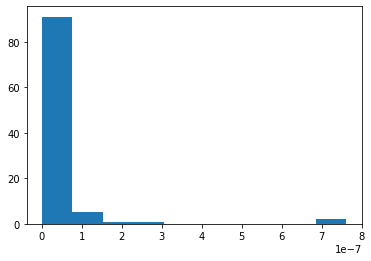

In [8]:
# It should have the shape of a normal distribution
plt.hist(p_values_means)
plt.show()

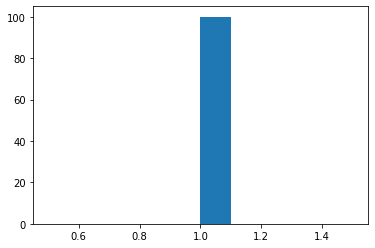

In [9]:
# It should have the shape of a normal distribution
plt.hist(proportion_means)
plt.show()

In [10]:
# Confidence Interval
def confidence_interval(sample):
    mean_hat = np.mean(sample)
    std_hat = np.std(sample)
    confidence_length = 2*(std_hat*1.96)/np.sqrt(len(sample))
    U = mean_hat + confidence_length/2
    L = mean_hat - confidence_length/2
    return L, mean_hat, U
# plt.plot(np.repeat(1, 3), [L,mean_hat, U])

In [11]:
# test_dist_sizes = np.linspace(10, 1000, 10).astype(int)
# pvalues_mean_sample = []
# proportion_mean_sample = []
# for tds in test_dist_sizes:
#     print(tds)
#     p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_final_NA'], population_movielens, ref_dist_size=10**4, test_dist_size=tds, N_bots=50, rounds=30)
#     pvalues_mean_sample.append(p_values_means)
#     proportion_mean_sample.append(proportion_means)

In [17]:
test_dist_sizes = np.linspace(10, 40, 4).astype(int)
pvalues_mean_sample = []
proportion_mean_sample = []
confidence_intervals = []
for tds in test_dist_sizes:
    print(tds)
    p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_final_NA'], population_movielens, ref_dist_size=10**4, test_dist_size=tds, N_bots=50, rounds=30)
    pvalues_mean_sample.append(p_values_means)
    proportion_mean_sample.append(proportion_means)

10
20
30
40


Text(0, 0.5, 'Proportion of Null Hypothesis Rejection')

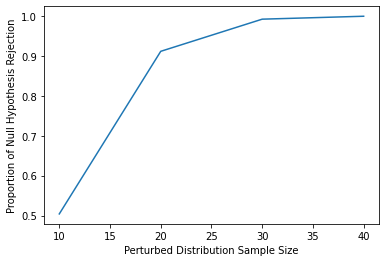

In [18]:
means = [np.mean(p) for p in proportion_mean_sample]
plt.plot(test_dist_sizes, means)
plt.xlabel("Perturbed Distribution Sample Size")
plt.ylabel("Proportion of Null Hypothesis Rejection")

Text(0, 0.5, 'Proportion of Null Hypothesis Rejection')

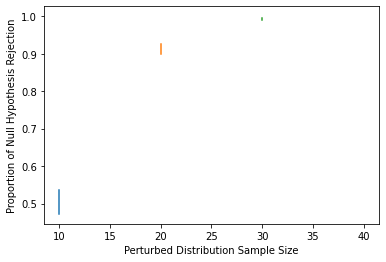

In [19]:

for i in range(len(proportion_mean_sample)):
    mean_sample = proportion_mean_sample[i]
    mean = np.mean(mean_sample)
    ci = 1.96 * np.std(mean_sample)/np.sqrt(len(mean_sample))
    plt.plot(np.repeat(test_dist_sizes[i], 3), [mean-ci, mean, mean+ci])

plt.xlabel("Perturbed Distribution Sample Size")
plt.ylabel("Proportion of Null Hypothesis Rejection")

In [17]:
def kstest_file(filename):
    try:
        with open(filename, 'r') as f:
            DATA = json.load(f)
        population = np.arange(len(DATA['p0']))
        file_result = open("./kstests/baseline/" + filename.split("/")[-1], "w")
        p_values_means, rejection_proportions_means = covertness_kstest(DATA['pi_bs'], DATA['pi_bs'], population, ref_dist_size=10**3, test_dist_size=10**2)
        file_result.write("p_values_mean: {}, rejection proportion: {}".format(p_values_mean, rejection_proportion))
        file_result.close()
    except Exception as e:
        print(e)

In [ ]:
def plot_rejection_proportion():
    

In [ ]:
files = os.listdir('./sim_results/')
movielens_simulations_files = match_regex_array(files, r'sim_results_Umovielens.*')
lastfm_simulations_files = match_regex_array(files, r'sim_results_Ulastfm.*')
ks_movielens = []
i = 0
end = movielens_size
for filename in movielens_simulations_files:
    print("{}/{}".format(i, end))
    kstest_file(filename)
    i+=1

0/1060
1/1060
2/1060
3/1060
4/1060
5/1060
6/1060
7/1060
8/1060
9/1060
10/1060
11/1060
12/1060
13/1060
14/1060
15/1060
16/1060


In [139]:
from scipy import stats
rv = stats.expon(scale=1/0.247)
rv.cdf(0.7)

0.1587782671880641

In [178]:
exp_samples = stats.expon(scale=1/0.247).rvs(size=10**6)

In [179]:
ks_1samp(exp_samples, stats.expon(scale=1/0.247).cdf)

KstestResult(statistic=0.000453357937850285, pvalue=0.9862728719610566)

In [181]:
# it seems that KStest doesn't work very well for discrete cdf. p value not making sense. It should be high.
def cdf_(X):
    if (type(X) == int):        
        r = sum(data_movielens['pi_bs'][:X])
    else:
        r = [sum(data_movielens['pi_bs'][:x]) for x in X]
    return r
population = np.arange(movielens_size)
samples = choices(population, data_movielens['pi_bs'], k=10**6)
ks_1samp(samples, cdf_)